In [1]:
import geopandas as gpd
import xarray as xr
import rioxarray 
from shapely.geometry import box
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

from geocube.api.core import make_geocube



root = Path.cwd()

In [2]:
polys = gpd.read_file(root / 'beech_stands' / 'Beech Stand Polygons.kml')
polys = polys.reset_index().to_crs(26918)

In [3]:
SITE = 'visitors'

sentinel = xr.open_dataarray(root / 'sentinel_data' / f'2023_{SITE}.nc')
# set crs and spatial dims
sentinel = sentinel.rio.write_crs(26918).rio.set_spatial_dims(x_dim="x",y_dim="y",).rio.write_coordinate_system()

In [4]:
# create bounding box polygon of sentinel array
bounds = sentinel.rio.bounds()
sentinel_bbox = box(*bounds)

# get the polygons that intersect with the bounding box
df = gpd.GeoDataFrame({"id":1,"geometry":[sentinel_bbox]})
idx = df.sindex.query(polys.geometry, predicate="intersects")[0]
polys_selected = polys.iloc[idx]
polys_selected.shape



(2, 14)

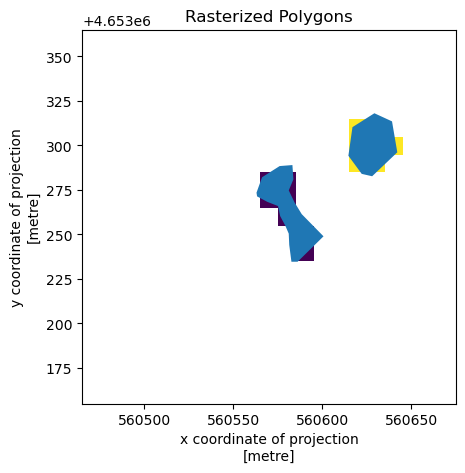

In [5]:
# rasterize polygons
out_grid = make_geocube(
    vector_data=polys_selected,
    measurements=["index"],
    like=sentinel, # ensure the data are on the same grid
)


 # plot rasterized polygons overlaid with vector polygons
fig, ax = plt.subplots(ncols=1, figsize=(5, 5))

p = out_grid.index.plot.imshow(ax=ax)
polys_selected.plot(ax=ax)
p.colorbar.remove()
plt.title('Rasterized Polygons')
plt.tight_layout()
plt.show()

In [6]:
# add satellite data to dataset
out_grid['sentinel'] = (sentinel.dims, sentinel.values, sentinel.attrs, sentinel.encoding)

In [7]:
# calculate means for each group (polygon)
grouped_sentinel = out_grid.drop_vars("spatial_ref").groupby(out_grid.index)
grid_mean = grouped_sentinel.mean().rename({"sentinel": "sentinel_mean"})

c:\Users\roseh\miniconda3\envs\beech-env\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension index because variable index is not a coordinate. To create an index for index, please first call `.set_coords('index')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


In [8]:
zonal_stats = grid_mean.to_dataframe()

# get index numbers for beech/nonbeech polygons
beech_idx = polys_selected.loc[polys_selected.Name!='non-beech stand']['index'].astype('float').values
nonbeech_idx = polys_selected.loc[polys_selected.Name=='non-beech stand']['index'].astype('float').values

# put beech/nonbeech into seperate dataframes 
beech_means = zonal_stats.loc[beech_idx]
nonbeech_means = zonal_stats.loc[nonbeech_idx]

In [33]:
import numpy as np

len(np.unique(beech_means.index.get_level_values(level='index')))

1

In [ ]:
def unstack_and_relabel_dfs(df,idx=None):

    df_unstack = df.unstack(level='band').droplevel('band',axis=1)
    df_unstack.columns = sentinel.band.values

    if len(np.unique(df_unstack.index.get_level_values(level='index'))) < 2: # check if multiple polygons
        df_unstack = df_unstack.reset_index()
        df_unstack['time'] = [str(x.astype('datetime64[D]')) for x in sentinel.time.values]
        return df_unstack
    
    else:
        df_list = []
        for i in range(0,len(idx)):
            df1 = df_unstack.loc[idx[i]]
            df1 = df1.reset_index()
            df1['time'] = [str(x.astype('datetime64[D]')) for x in sentinel.time.values]
            df_list.append(df1)
        
        return df_list
        

        

In [35]:
# reformat and label dataframes
beech_means = unstack_and_relabel_dfs(beech_means)
nonbeech_means = unstack_and_relabel_dfs(nonbeech_means)


In [38]:
beech_means.to_csv(root / 'output' / f'{SITE}_beech_polygon_means.csv')
nonbeech_means.to_csv(root / 'output' / f'{SITE}_nonbeech_polygon_means.csv')
